# Pandas Series and Dataframe testing

Pandas introduces the Series object, which stores an array of data against several dimensions of columns. These can be merged into a DataFrame object, which acts like a table of this high-dimensional data.

Currently, the goal is to upgrade from a two-dimensional dataframe of (dates, samples) to an optional three-dimensional (dates, samples, groups) model. Only some of these Series may contain this extra dimension of data, and some may contain data for a subset of groups.

The goal is therefore to find a way to combine these series into a dataframe safely and preserving data.

In [1]:
import os
import sys

def to_base_cwd():
    os.chdir(os.path.join(os.getcwd(), '../..'))

os.getcwd()

'/home/james/eam-core-provenance/docs/ipynb'

In [2]:
#to_base_cwd()
os.getcwd()

'/home/james/eam-core-provenance/docs/ipynb'

In [3]:
import pandas as pd 
import pint
import numpy as np
import pickle

## Creating Series

First, the series data must be loaded or generated.

- When loading series, the data is obtained from pickling the calculation traces in `util.py store_dataframe()`.

- When generating a series, we can introduce data that models some of the acceptable edge cases expected; without countries or using only a subset of countries. 

In [4]:
def load_series_from_files():
    res = []
    res.append(pd.read_pickle('pickle_data/pickles/Datacentres.pickle'))
    res.append(pd.read_pickle('pickle_data/pickles/Cellular.pickle'))
    res.append(pd.read_pickle('pickle_data/pickles/Fixed Line.pickle'))
    res.append(pd.read_pickle('pickle_data/pickles/CDN.pickle'))
    res.append(pd.read_pickle('pickle_data/pickles/Modem Router.pickle'))
    res.append(pd.read_pickle('pickle_data/pickles/End User Device.pickle'))
    
    return res

def generate_series_list():
    times = pd.date_range('2020-01-01', '2020-3-01', freq='MS')
    sample_size = 3
    groups_full = ['A', 'B', 'C']
    
    series_length = len(times) * sample_size * len(groups_full)
    index_names_full = ['time', 'samples', 'group']

    
    iterables = [times, range(sample_size), groups_full]
    df_multi_index = pd.MultiIndex.from_product(iterables, names=index_names_full)
    s1 = pd.Series(data=range(series_length), index=df_multi_index, name='FULL_A')
    
    iterables = [times, range(sample_size), groups_full[:2]]
    df_multi_index = pd.MultiIndex.from_product(iterables, names=index_names_full)
    s2 = pd.Series(data=range(int(series_length * 2/3)), index=df_multi_index, name='TWO_COUNTRIES')
    
    iterables = [times, range(sample_size)]
    df_multi_index = pd.MultiIndex.from_product(iterables, names=index_names_full[:2])
    s3 = pd.Series(data=range(int(series_length / 3)), index=df_multi_index, name='NO_GROUPS_A')  
    
    iterables = [times, range(sample_size), groups_full[:1]]
    df_multi_index = pd.MultiIndex.from_product(iterables, names=index_names_full)
    s4 = pd.Series(data=range(int(series_length * 1/3)), index=df_multi_index, name='ONE_COUNTRY')
    
    iterables = [times, range(sample_size)]
    df_multi_index = pd.MultiIndex.from_product(iterables, names=index_names_full[:2])
    s5 = pd.Series(data=range(int(series_length / 3)), index=df_multi_index, name='NO_GROUPS_B')
    
    return [s1,s2,s3,s4,s5]

def get_generated_series_indexing():
    times = pd.date_range('2020-01-01', '2020-3-01', freq='MS')
    sample_size = 3
    groups = ['A', 'B', 'C']
    
    iterables = [times, range(sample_size), groups]
    
    return iterables, times

## Interacting with Series

Here, series are loaded as a list.

When combining series into the empty dataframe, they must only decrease in dimensionality, or an error is thrown.

So, its fine if the series are ordered in decreasing dimensionality; but this is time-consuming and there ought to be a better way.

The solution is to generate the dataframe with a defined multi-index of the maximum possible dimensions and groups. This way, every series is a non-strict subset of the DataFrame, and errors are avoided.

### How series are merged

Interesting to note is _how_ pandas performs the merge.

- One case is when merging a series with the same dimensionality, but a subset in an index. For example, only one or two countries of a possible three. Here, the missing data is filled in with `NaN` (and, presumably as a result, the other values are interpreted as floats; TODO need to check this with Pint to investigate the effect this has with Pint value arrays!

- The other case is when a dimension is missing entirely, for example if a series without group data is merged. In this case, the data is duplicated across the new dimension.

In [5]:
series = generate_series_list()
#series = load_series_from_files()
len(series)

5

In [6]:
for s in series:
    #print(s)
    continue

In [7]:
#cdn = series[3]
#print(cdn.index.get_level_values('group').values)
#cdn

In [8]:
df_blank = pd.DataFrame()
for i in range(len(series)):
    print(series[i].shape)
    #df_blank[str(i)] = series[len(series)-i-1]
    #df_blank[str(i)] = series[i]
df_blank

(27,)
(18,)
(9,)
(9,)
(9,)


""


In [9]:
times = pd.date_range('2020-01-01', '2020-01-01', freq='MS')
sample_size = 1
groups = ['A', 'B']
iterables = [times, range(sample_size), groups]
index_names = ['time', 'samples', 'group']

#don't call this if using pickle data
iterables, times = get_generated_series_indexing()

df_multi_index = pd.MultiIndex.from_product(iterables, names=index_names)
df_index = pd.DataFrame(index=df_multi_index)

for i in range(len(series)):
    print(series[i].shape)
    if 'group' in series[i].index.names:
        print(set(series[i].index.get_level_values('group').values))
    #df_index[str(i)] = series[len(series)-i-1]
    if series[i].name is None: series[i].name = str(i)
    df_index[series[i].name] = series[i]
    
# this demonstrates that different shaped series can be merged into a dataframe
df_index

(27,)
{'C', 'A', 'B'}
(18,)
{'A', 'B'}
(9,)
(9,)
{'A'}
(9,)


FULL_A  TWO_COUNTRIES  NO_GROUPS_A  ONE_COUNTRY  \
time       samples group                                                    
2020-01-01 0       A           0            0.0            0          0.0   
                   B           1            1.0            0          NaN   
                   C           2            NaN            0          NaN   
           1       A           3            2.0            1          1.0   
                   B           4            3.0            1          NaN   
                   C           5            NaN            1          NaN   
           2       A           6            4.0            2          2.0   
                   B           7            5.0            2          NaN   
                   C           8            NaN            2          NaN   
2020-02-01 0       A           9            6.0            3          3.0   
                   B          10            7.0            3          NaN   
                   C          11            NaN            3          NaN   
           1       A          12            8.0            4          4.0   
                   B          13            9.0            4          NaN   
                   C          14            NaN            4          NaN   
           2       A          15           10.0            5          5.0   
                   B          16           11.0            5          NaN   
                   C          17            NaN            5          NaN   
2020-03-01 0       A          18           12.0            6          6.0   
                   B          19           13.0            6          NaN   
                   C          20            NaN            6          NaN   
           1       A          21           14.0            7          7.0   
                   B          22           15.0            7          NaN   
                   C          23            NaN            7          NaN   
           2       A          24           16.0            8          8.0   
                   B          25           17.0            8          NaN   
                   C          26            NaN            8          NaN   

                          NO_GROUPS_B  
time       samples group               
2020-01-01 0       A                0  
                   B                0  
                   C                0  
           1       A                1  
                   B                1  
                   C                1  
           2       A                2  
                   B                2  
                   C                2  
2020-02-01 0       A                3  
                   B                3  
                   C                3  
           1       A                4  
                   B                4  
                   C                4  
           2       A                5  
                   B                5  
                   C                5  
2020-03-01 0       A                6  
                   B                6  
                   C                6  
           1       A                7  
                   B                7  
                   C                7  
           2       A                8  
                   B                8  
                   C                8

In [10]:
from eam_core import util
data, metadata = util.h5load('pickle_data/carbon_countrytest.hdf5')
data.head(5)

[root                ][INFO   ]  Configured logging from /home/james/eam-core-provenance/src/eam_core/logconf.yml (log_configuration.py:30)


CDN Internet Network         Laptop
unit                     megametric_ton   megametric_ton megametric_ton
time       samples group                                               
2019-01-01 0       A       2.500000e-11     2.500000e-11   2.000000e-07
                   B       2.500000e-11     2.500000e-11   2.000000e-07
2019-02-01 0       A       2.500000e-11     2.500000e-11   2.000000e-07
                   B       2.500000e-11     2.500000e-11   2.000000e-07
2019-03-01 0       A       2.500000e-11     2.500000e-11   2.000000e-07

In [11]:
data_carbon, metadata_carbon = util.h5load('pickle_data/result_data_carbon.hdf5')
data_carbon2 = data_carbon.reorder_levels([2,0,1])
data_carbon

Datacentres Fixed Line   Cellular      CDN  \
unit                        kilogram   kilogram   kilogram kilogram   
time       samples group                                              
2020-01-01 0       A       83.333333   6.848438   45.65625   1250.0   
                   B       83.333333  13.696875   91.31250   2500.0   
                   C       83.333333  20.545313  136.96875   3750.0   
           1       A       83.333333   6.848438   45.65625   1250.0   
                   B       83.333333  13.696875   91.31250   2500.0   
                   C       83.333333  20.545313  136.96875   3750.0   
           2       A       83.333333   6.848438   45.65625   1250.0   
                   B       83.333333  13.696875   91.31250   2500.0   
                   C       83.333333  20.545313  136.96875   3750.0   
2020-02-01 0       A       83.333333   6.848438   45.65625   1250.0   
                   B       83.333333  13.696875   91.31250   2500.0   
                   C       83.333333  20.545313  136.96875   3750.0   
           1       A       83.333333   6.848438   45.65625   1250.0   
                   B       83.333333  13.696875   91.31250   2500.0   
                   C       83.333333  20.545313  136.96875   3750.0   
           2       A       83.333333   6.848438   45.65625   1250.0   
                   B       83.333333  13.696875   91.31250   2500.0   
                   C       83.333333  20.545313  136.96875   3750.0   
2020-03-01 0       A       83.333333   6.848438   45.65625   1250.0   
                   B       83.333333  13.696875   91.31250   2500.0   
                   C       83.333333  20.545313  136.96875   3750.0   
           1       A       83.333333   6.848438   45.65625   1250.0   
                   B       83.333333  13.696875   91.31250   2500.0   
                   C       83.333333  20.545313  136.96875   3750.0   
           2       A       83.333333   6.848438   45.65625   1250.0   
                   B       83.333333  13.696875   91.31250   2500.0   
                   C       83.333333  20.545313  136.96875   3750.0   
2020-04-01 0       A       83.333333   6.848438   45.65625   1250.0   
                   B       83.333333  13.696875   91.31250   2500.0   
                   C       83.333333  20.545313  136.96875   3750.0   
           1       A       83.333333   6.848438   45.65625   1250.0   
                   B       83.333333  13.696875   91.31250   2500.0   
                   C       83.333333  20.545313  136.96875   3750.0   
           2       A       83.333333   6.848438   45.65625   1250.0   
                   B       83.333333  13.696875   91.31250   2500.0   
                   C       83.333333  20.545313  136.96875   3750.0   

                         Modem Router End User Device  
unit                         kilogram        kilogram  
time       samples group                               
2020-01-01 0       A         4.002227        0.913125  
                   B         8.004454        1.826250  
                   C        12.006681        2.739375  
           1       A         4.002227        0.913125  
                   B         8.004454        1.826250  
                   C        12.006681        2.739375  
           2       A         4.002227        0.913125  
                   B         8.004454        1.826250  
                   C        12.006681        2.739375  
2020-02-01 0       A         4.002227        0.913125  
                   B         8.004454        1.826250  
                   C        12.006681        2.739375  
           1       A         4.002227        0.913125  
                   B         8.004454        1.826250  
                   C        12.006681        2.739375  
           2       A         4.002227        0.913125  
                   B         8.004454        1.826250  
                   C        12.006681        2.739375  
2020-03-01 0       A         4.002227        0.913125  
                   B   

In [12]:
data_energy, metadata_energy = util.h5load('pickle_data/result_data_energy.hdf5')
data_energy

Fixed Line      Cellular           CDN  \
unit                     kilowatt_hour kilowatt_hour kilowatt_hour   
time       samples group                                             
2020-01-01 0       A         22.828125      152.1875   4166.666667   
                   B         22.828125      152.1875   4166.666667   
                   C         22.828125      152.1875   4166.666667   
           1       A         22.828125      152.1875   4166.666667   
                   B         22.828125      152.1875   4166.666667   
                   C         22.828125      152.1875   4166.666667   
           2       A         22.828125      152.1875   4166.666667   
                   B         22.828125      152.1875   4166.666667   
                   C         22.828125      152.1875   4166.666667   
2020-02-01 0       A         22.828125      152.1875   4166.666667   
                   B         22.828125      152.1875   4166.666667   
                   C         22.828125      152.1875   4166.666667   
           1       A         22.828125      152.1875   4166.666667   
                   B         22.828125      152.1875   4166.666667   
                   C         22.828125      152.1875   4166.666667   
           2       A         22.828125      152.1875   4166.666667   
                   B         22.828125      152.1875   4166.666667   
                   C         22.828125      152.1875   4166.666667   
2020-03-01 0       A         22.828125      152.1875   4166.666667   
                   B         22.828125      152.1875   4166.666667   
                   C         22.828125      152.1875   4166.666667   
           1       A         22.828125      152.1875   4166.666667   
                   B         22.828125      152.1875   4166.666667   
                   C         22.828125      152.1875   4166.666667   
           2       A         22.828125      152.1875   4166.666667   
                   B         22.828125      152.1875   4166.666667   
                   C         22.828125      152.1875   4166.666667   
2020-04-01 0       A         22.828125      152.1875   4166.666667   
                   B         22.828125      152.1875   4166.666667   
                   C         22.828125      152.1875   4166.666667   
           1       A         22.828125      152.1875   4166.666667   
                   B         22.828125      152.1875   4166.666667   
                   C         22.828125      152.1875   4166.666667   
           2       A         22.828125      152.1875   4166.666667   
                   B         22.828125      152.1875   4166.666667   
                   C         22.828125      152.1875   4166.666667   

                          Modem Router End User Device  
unit                     kilowatt_hour   kilowatt_hour  
time       samples group                                
2020-01-01 0       A         13.340756         3.04375  
                   B         13.340756         3.04375  
                   C         13.340756         3.04375  
           1       A         13.340756         3.04375  
                   B         13.340756         3.04375  
                   C         13.340756         3.04375  
           2       A         13.340756         3.04375  
                   B         13.340756         3.04375  
                   C         13.340756         3.04375  
2020-02-01 0       A         13.340756         3.04375  
                   B         13.340756         3.04375  
                   C         13.340756         3.04375  
           1       A         13.340756         3.04375  
                   B         13.340756         3.04375  
                   C         13.340756         3.04375  
           2       A         13.340756         3.04375  
                   B         13.340756         3.04375  
                   C         13.340756         3.04375  
2020-03-01 0       A         13.340756         3.04375  
                   B         13.340756     

In [13]:
series = generate_series_list()
# can handle operations on series with missing countries
s1 = series[1] / series[0] * series[2]

# can handle operations on series with different dimensions
s2 = series[0] + series[1]

# can sum, max, etc through series with NaN values
sum_series = s1.sum()
max_series = s1.max()
print(sum_series, max_series)
print(s1.tolist()[0], type(s1.tolist()[0]))

series = generate_series_list()
iterables, times = get_generated_series_indexing()
index_names = ['time', 'samples', 'group']

df_multi_index = pd.MultiIndex.from_product(iterables, names=index_names)
df2 = pd.DataFrame(index=df_multi_index)

df2['series0'] = series[0]
df2['series1'] = series[1]
df2['0+1'] = s2
df2
s2.mean(level=('group', 'time'))



48.80329262842421 5.44
nan <class 'float'>


/tmp/ipykernel_26967/963421157.py:25: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  s2.mean(level=('group', 'time'))


group  time      
A      2020-01-01     5.0
B      2020-01-01     7.0
C      2020-01-01     NaN
A      2020-02-01    20.0
B      2020-02-01    22.0
C      2020-02-01     NaN
A      2020-03-01    35.0
B      2020-03-01    37.0
C      2020-03-01     NaN
dtype: float64

In [14]:
series = generate_series_list()
iterables, times = get_generated_series_indexing()
index_names = ['time', 'samples', 'group']

df_multi_index = pd.MultiIndex.from_product(iterables, names=index_names)
df1 = pd.DataFrame(index=df_multi_index)
df2 = pd.DataFrame(index=df_multi_index)


In [15]:
def load_countrytest_series_from_files():
    res = []
    res.append(pd.read_pickle('pickle_data/countrytest/Origin Datacentre.pickle'))
    res.append(pd.read_pickle('pickle_data/countrytest/Internet Network.pickle'))
    res.append(pd.read_pickle('pickle_data/countrytest/CDN.pickle'))
    res.append(pd.read_pickle('pickle_data/countrytest/Access Network.pickle'))
    res.append(pd.read_pickle('pickle_data/countrytest/Laptop.pickle'))
    
    return res

In [16]:
countryres = load_countrytest_series_from_files()

times = pd.date_range('2020-01-01', '2020-01-01', freq='MS')
sample_size = 1
groups = ['A', 'B', 'DE']
iterables = [times, range(sample_size), groups]
index_names = ['time', 'samples', 'group']

df_multi_index = pd.MultiIndex.from_product(iterables, names=index_names)
df_index = pd.DataFrame(index=df_multi_index)

for i in range(len(series)):
    print(countryres[i].shape)
    df_index[str(i)] = countryres[i]

df_index

(1, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)


0         1         2         3         4
time       samples group                                                  
2020-01-01 0       A           NaN  0.142718  1.427182  0.010572  0.021143
                   B           NaN  0.570873  2.854365  0.042287  0.084574
                   DE     0.856309       NaN       NaN       NaN       NaN

In [17]:
countryres = load_series_from_files()

times = pd.date_range('2020-01-01', '2020-01-01', freq='MS')
sample_size = 1
groups = ['A', 'B']
iterables = [times, range(sample_size), groups]
index_names = ['time', 'samples', 'group']

df_multi_index = pd.MultiIndex.from_product(iterables, names=index_names)
df_index_energy = pd.DataFrame(index=df_multi_index)
df_index_carbon = pd.DataFrame(index=df_multi_index)

for i in range(len(countryres)):
    # print(countryres[i].shape)
    cols = countryres[i].columns
    df_index_energy[cols[0][0]] = countryres[i][cols[0][0]]
    df_index_carbon[cols[1][0]] = countryres[i][cols[1][0]]

In [18]:
df_index_carbon

Datacentres_carbon  Cellular_carbon  \
time       samples group                                        
2020-01-01 0       A               83.333333         45.65625   
                   B               83.333333        182.62500   

                          Fixed Line_carbon  CDN_carbon  Modem Router_carbon  \
time       samples group                                                       
2020-01-01 0       A               6.848438      1250.0             4.002227   
                   B              27.393750      2500.0            16.008908   

                          End User Device_carbon  
time       samples group                          
2020-01-01 0       A                    0.913125  
                   B                    3.652500

In [19]:
data_carbon, metadata_carbon = util.h5load('/home/james/dimpact-api/output/0/simplified_model/20210818-124927/result_data_energy.hdf5')
#print(data_carbon.index)
#data_carbon.reorder_levels(['time', 'group', 'samples']).mean(level='group').sum(level='group')
data_carbon

_d = data_carbon.mean(level='time').sum()
_d
data_carbon

/tmp/ipykernel_26967/1822650438.py:6: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  _d = data_carbon.mean(level='time').sum()


Fixed Line      Cellular           CDN  \
unit                     kilowatt_hour kilowatt_hour kilowatt_hour   
time       samples group                                             
2020-01-01 0       B         22.828125      152.1875   4166.666667   
                   A         22.828125      152.1875   4166.666667   
2020-02-01 0       B         22.828125      152.1875   4166.666667   
                   A         22.828125      152.1875   4166.666667   
2020-03-01 0       B         45.656250      304.3750   4166.666667   
                   A         45.656250      304.3750   4166.666667   
2020-04-01 0       B         45.656250      304.3750   4166.666667   
                   A         45.656250      304.3750   4166.666667   

                          Modem Router End User Device  
unit                     kilowatt_hour   kilowatt_hour  
time       samples group                                
2020-01-01 0       B         13.340756         3.04375  
                   A         13.340756         3.04375  
2020-02-01 0       B         13.340756         3.04375  
                   A         13.340756         3.04375  
2020-03-01 0       B         26.681513         6.08750  
                   A         26.681513         6.08750  
2020-04-01 0       B         26.681513         6.08750  
                   A         26.681513         6.08750

In [1]:
_d_countrified = data_carbon.mean(level=['time', 'group']).sum(level='group').T

_d_countrified['Total'] = _d_countrified.sum()
_d_countrified

NameError: name 'data_carbon' is not defined

In [7]:
import pandas as pd
data_energy = pd.read_pickle('pickle_data/result_data_full_energy.pkl')
data_carbon = pd.read_pickle('pickle_data/result_data_full_carbon.pkl')

data_energy

Storage  Datacentres  Cellular  Fixed Line  \
Scenario          group                                                    
FRITZ_WIN10_VIDEO A 1    3.994042e-07     0.000541   0.00612     0.00012   
                  B 2    3.994042e-07     0.001083   0.01224     0.00024   
                  C 3    3.994042e-07     0.001624   0.01836     0.00036   
                  D 4    3.994042e-07     0.002165   0.02448     0.00048   
                  E 5    3.994042e-07     0.002707   0.03060     0.00060   
...                               ...          ...       ...         ...   
default           L 13   3.994042e-07     0.006496   0.07344     0.00144   
                  M 14   3.994042e-07     0.007037   0.07956     0.00156   
                  N 15   3.994042e-07     0.007578   0.08568     0.00168   
                  O 16   3.994042e-07     0.008120   0.09180     0.00180   
                  P 16   3.994042e-07     0.008661   0.09792     0.00192   

                             CPE  End User Device  
Scenario          group                            
FRITZ_WIN10_VIDEO A 1    0.00008         0.008628  
                  B 2    0.00016         0.017256  
                  C 3    0.00024         0.025884  
                  D 4    0.00032         0.034512  
                  E 5    0.00040         0.043140  
...                          ...              ...  
default           L 13   0.00096         0.226975  
                  M 14   0.00104         0.245889  
                  N 15   0.00112         0.264804  
                  O 16   0.00120         0.283719  
                  P 16   0.00128         0.302633  

[496 rows x 6 columns]

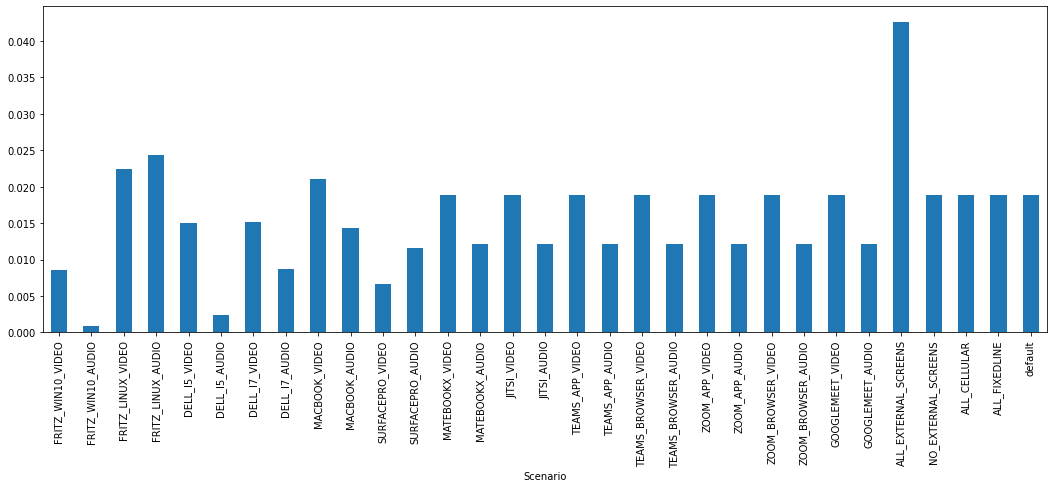

In [14]:
data_energy_reordered = data_energy.reorder_levels(['group', 'Scenario'])
data_energy_reordered.loc['A 1']['End User Device'].plot.bar(figsize=(18,6))

In [16]:
scenarios = {
'FRITZ_WIN10_VIDEO': 'Windows 10 Desktop',
'FRITZ_WIN10_AUDIO': 'Windows 10 Desktop',
'FRITZ_LINUX_VIDEO': 'Linux Desktop',
'FRITZ_LINUX_AUDIO': 'Linux Desktop',
'DELL_I5_VIDEO': 'Dell i5 Laptop',
'DELL_I5_AUDIO': 'Dell i5 Laptop',
'DELL_I7_VIDEO': 'Dell i7 Laptop',
'DELL_I7_AUDIO': 'Dell i7 Laptop',
'MACBOOK_VIDEO': 'Macbook Pro 2015',
'MACBOOK_AUDIO': 'Macbook Pro 2015',
'SURFACEPRO_VIDEO': 'Surface ',
'SURFACEPRO_AUDIO': '',
'MATEBOOKX_VIDEO': '',
'MATEBOOKX_AUDIO': '',
'JITSI_VIDEO': '',
'JITSI_AUDIO': '',
'TEAMS_APP_VIDEO': '',
'TEAMS_APP_AUDIO': '',
'TEAMS_BROWSER_VIDEO': '',
'TEAMS_BROWSER_AUDIO': '',
'ZOOM_APP_VIDEO': '',
'ZOOM_APP_AUDIO': '',
'ZOOM_BROWSER_VIDEO': '',
'ZOOM_BROWSER_AUDIO': '',
'GOOGLEMEET_VIDEO': '',
'GOOGLEMEET_AUDIO': '',
'ALL_EXTERNAL_SCREENS': '',
'NO_EXTERNAL_SCREENS': '',
'ALL_CELLULAR': '',
'ALL_FIXEDLINE': '', }

In [24]:
import numpy as np

networking_platforms = ['Teams App', 'Teams Browser', 'Zoom App', 'Zoom Browser', 'Google Meet', 'Jitsi Meet']
networking_avg_video = np.array([3949, 4900, 2177, 1716, 1109, 3880])
networking_avg_audio = np.array([77, 72, 180, 168, 71, 148.5])

networking_min_video = np.array([3133, 4877, 1955, 1714, 976, 3879])
networking_max_video = np.array([4543, 4923, 2488, 1717, 1333, 3881])
networking_min_audio = np.array([69, 72, 173, 162, 60, 147])
networking_max_audio = np.array([85, 72, 184, 174, 82, 150])


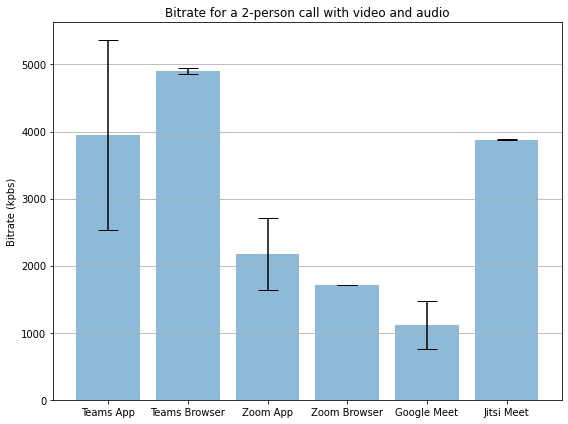

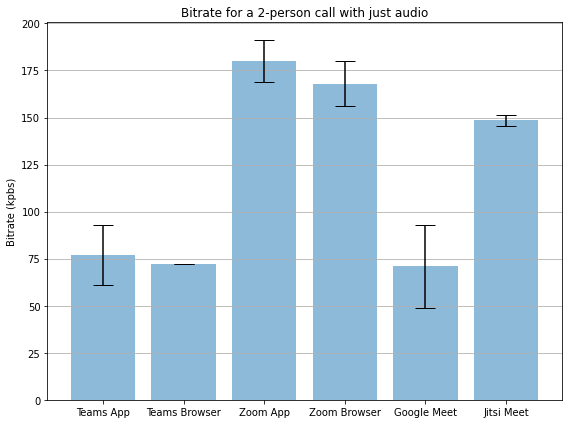

In [33]:
# Build the plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(np.arange(len(networking_platforms)), networking_avg_video, yerr=networking_max_video-networking_min_video, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Bitrate (kpbs)')
ax.set_xticks(np.arange(len(networking_platforms)))
ax.set_xticklabels(networking_platforms)
ax.set_title('Bitrate for a 2-person call with video and audio')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('networking_avg_video.pdf')
plt.show()

# just audio!
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(np.arange(len(networking_platforms)), networking_avg_audio, yerr=networking_max_audio-networking_min_audio, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Bitrate (kpbs)')
ax.set_xticks(np.arange(len(networking_platforms)))
ax.set_xticklabels(networking_platforms)
ax.set_title('Bitrate for a 2-person call with just audio')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('networking_avg_audio.pdf')
plt.show()